# Import library 

In [1]:
pip install twython 

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 7.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 8.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, init
import plotly.express as px

import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
from collections import Counter
from wordcloud import WordCloud




nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/haleychen/nltk_data...
[nltk_data] Downloading package punkt to /Users/haleychen/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/haleychen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load data

In [9]:
df = pd.read_csv("/Users/haleychen/Downloads/sentimentdataset.csv")

****Columns :****

* Text: Text content of the post.
* Sentiment: Sentiment of the post (positive, negative, or neutral).
* Timestamp: Date and time of the post.
* User: Username of the poster.
* Platform: Social media platform where the post was made (Twitter, Instagram, Facebook).
* Hashtags: Hashtags used in the post.
* Retweets: Number of retweets for the post.
* Likes: Number of likes for the post.
* Country: Country of origin for the poster.
* Year: Year in which the post was made.
* Month: Month in which the post was made.
* Day: Day of the month on which the post was made.
* Hour: Hour of the day at which the post was made.

In [11]:
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [15]:
def null_count():
    return pd.DataFrame({'features': df.columns,
                'dtypes': df.dtypes.values,
                'NaN count': df.isnull().sum().values,
                'NaN percentage': df.isnull().sum().values/df.shape[0]}).style.background_gradient(cmap='Set3',low=0.1,high=0.01)
null_count()

,features,dtypes,NaN count,NaN percentage
0,Unnamed: 0.1,int64,0,0.000000
1,Unnamed: 0,int64,0,0.000000
2,Text,object,0,0.000000
3,Sentiment,object,0,0.000000
4,Timestamp,object,0,0.000000
5,User,object,0,0.000000
6,Platform,object,0,0.000000
7,Hashtags,object,0,0.000000
8,Retweets,float64,0,0.000000
9,Likes,float64,0,0.000000


In [17]:
df.duplicated().sum()

0

In [19]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour'],
      dtype='object')

In [21]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

Unnamed: 0.1: 732 distinct values
Unnamed: 0: 732 distinct values
Text: 707 distinct values
Sentiment: 279 distinct values
Timestamp: 683 distinct values
User: 685 distinct values
Platform: 4 distinct values
Hashtags: 697 distinct values
Retweets: 26 distinct values
Likes: 38 distinct values
Country: 115 distinct values
Year: 14 distinct values
Month: 12 distinct values
Day: 31 distinct values
Hour: 22 distinct values


# Feature Enginering
 


In [24]:
# drop columns that we do not need 
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Hashtags','Day', 'Hour','Sentiment'])

In [28]:
# Looking at the different platforms. 
df['Platform'].value_counts() 

Platform
Instagram     258
Facebook      231
Twitter       128
Twitter       115
Name: count, dtype: int64

In [30]:
df['Platform'] = df['Platform'].str.strip() #his method removes any leading (spaces before the text) 

In [32]:
df['Country'].value_counts()

Country
USA               59
USA               55
UK                49
Canada            44
Australia         41
                  ..
Netherlands        1
USA                1
Germany            1
France             1
USA                1
Name: count, Length: 115, dtype: int64

In [34]:
df['Country'] = df['Country'].str.strip()

In [36]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Day_of_Week'] = df['Timestamp'].dt.day_name()

In [38]:
month_mapping = {
    1: 'Januari',
    2: 'Februari',
    3: 'Maret',
    4: 'April',
    5: 'Mei',
    6: 'Juni',
    7: 'Juli',
    8: 'Agustus',
    9: 'September',
    10: 'Oktober',
    11: 'November',
    12: 'Desember'
}

df['Month'] = df['Month'].map(month_mapping)

df['Month'] = df['Month'].astype('object')

## pre- processing the text columns 


In [41]:
'''
this function cleans up the text column by using skills such as remove unwanted symbols, 
tokenize words, as well as reduce the words into its stem form.'''



stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text.strip())
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)  
    text = " ".join(text.split())
    tokens = word_tokenize(text)
    
    cleaned_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stop_words]
   
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

df["Clean_Text"] = df["Text"].apply(clean)

In [43]:
'''This code cell counts and prints the number of unique values in each column.
Displays the most frequent values in each column, using different colors for better readability. '''



specified_columns = ['Platform','Country', 'Year','Month','Day_of_Week']

for col in specified_columns:
    total_unique_values = df[col].nunique()
    print(f'Total unique values for {col}: {total_unique_values}')

    top_values = df[col].value_counts()

    colors = [Fore.RED, Fore.GREEN, Fore.YELLOW, Fore.BLUE, Fore.MAGENTA, Fore.CYAN, Fore.WHITE, Fore.LIGHTBLACK_EX, Fore.LIGHTRED_EX, Fore.LIGHTGREEN_EX]

    for i, (value, count) in enumerate(top_values.items()):
        color = colors[i % len(colors)]
        print(f'{color}{value}: {count}{Fore.RESET}')

    print('\n' + '=' * 30 + '\n')  

Total unique values for Platform: 3
Instagram: 258
Twitter: 243
Facebook: 231


Total unique values for Country: 33
USA: 188
UK: 143
Canada: 135
Australia: 75
India: 70
Brazil: 17
France: 16
Japan: 15
Germany: 14
Italy: 11
Spain: 6
South Africa: 6
Greece: 5
Netherlands: 4
Switzerland: 3
Portugal: 2
Austria: 2
Belgium: 2
Denmark: 2
Czech Republic: 2
Sweden: 2
Colombia: 1
Scotland: 1
Kenya: 1
Jamaica: 1
Ireland: 1
China: 1
Norway: 1
Cambodia: 1
Maldives: 1
Peru: 1
Jordan: 1
Thailand: 1


Total unique values for Year: 14
2023: 289
2019: 73
2020: 69
2021: 63
2022: 63
2018: 56
2017: 43
2016: 38
2015: 19
2011: 4
2012: 4
2013: 4
2014: 4
2010: 3


Total unique values for Month: 12
Februari: 85
Januari: 82
Agustus: 78
September: 77
Juni: 71
Juli: 62
April: 51
November: 49
Oktober: 48
Mei: 46
Maret: 44
Desember: 39


Total unique values for Day_of_Week: 7
Sunday: 119
Saturday: 115
Tuesday: 110
Friday: 108
Monday: 97
Thursday: 95
Wednesday: 88




# EDA 


In [45]:
df1 = df.copy() # make a deep copy. 

# sentiment analysis 

In [50]:
analyzer = SentimentIntensityAnalyzer()

df1['Vader_Score'] = df1['Clean_Text'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

df1['Sentiment'] = df1['Vader_Score'].apply(lambda score: 'positive' if score >= 0.05 else ('negative' if score <= -0.05 else 'neutral'))

print(df1[['Clean_Text', 'Vader_Score', 'Sentiment']].head(10))



'''The VADER (Valence Aware Dictionary and sEntiment Reasoner) is a sentiment analysis tool 
designed to analyze text and determine its sentiment polarity (positive, neutral, or negative). 
It is particularly effective for social media, reviews, and short-form text because it considers 
word intensity, capitalization, punctuation, and even emojis.'''

                              Clean_Text  Vader_Score Sentiment
0                  enjoy beauti day park       0.4939  positive
1                   traffic terribl morn       0.0000   neutral
2                    finish amaz workout       0.0000   neutral
3            excit upcom weekend getaway       0.0000   neutral
4           tri new recip dinner tonight       0.0000   neutral
5            feel grate littl thing life       0.0000   neutral
6  raini day call cozi blanket hot cocoa       0.0000   neutral
7              new movi releas mustwatch       0.0000   neutral
8             polit discuss heat timelin       0.0000   neutral
9             miss summer vibe beach day      -0.1531  negative


### visualization

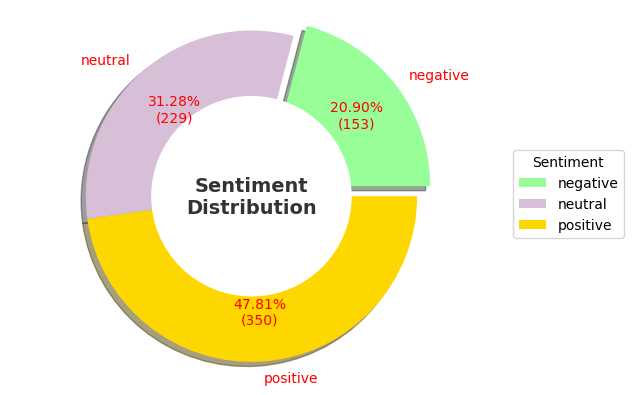

In [60]:
colors = ['#98FF98', '#D8BFD8', '#FFD700']

explode = (0.1, 0, 0)  

sentiment_counts = df1.groupby("Sentiment").size()

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=sentiment_counts, 
    labels=sentiment_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(sentiment_counts)/100)})', 
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="r"),  
    pctdistance=0.7,
    colors=colors,
    explode=explode,
    shadow=True)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(sentiment_counts.index, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  

plt.show()

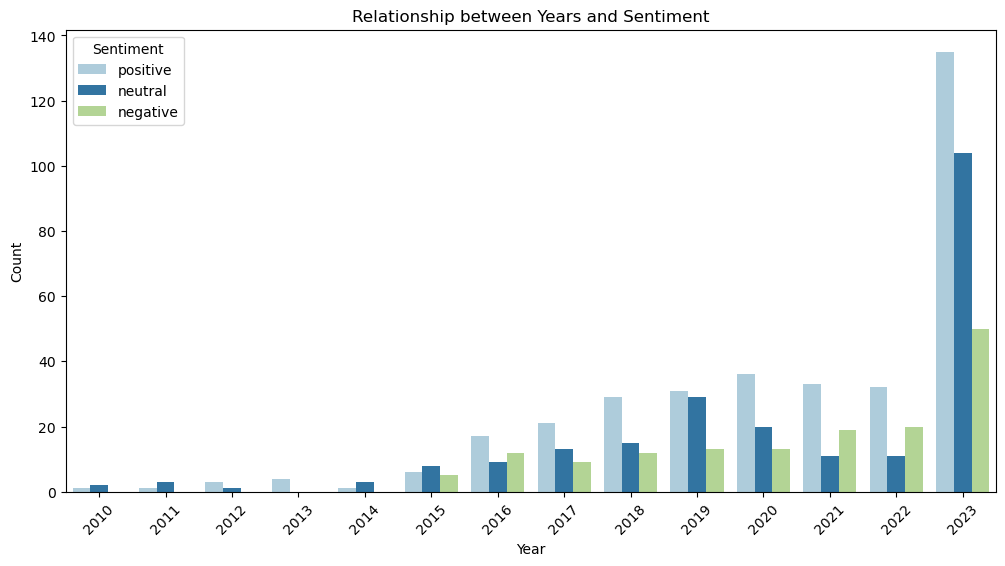

In [62]:
#year 


plt.figure(figsize=(12, 6))
sns.countplot(x='Year', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Years and Sentiment')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

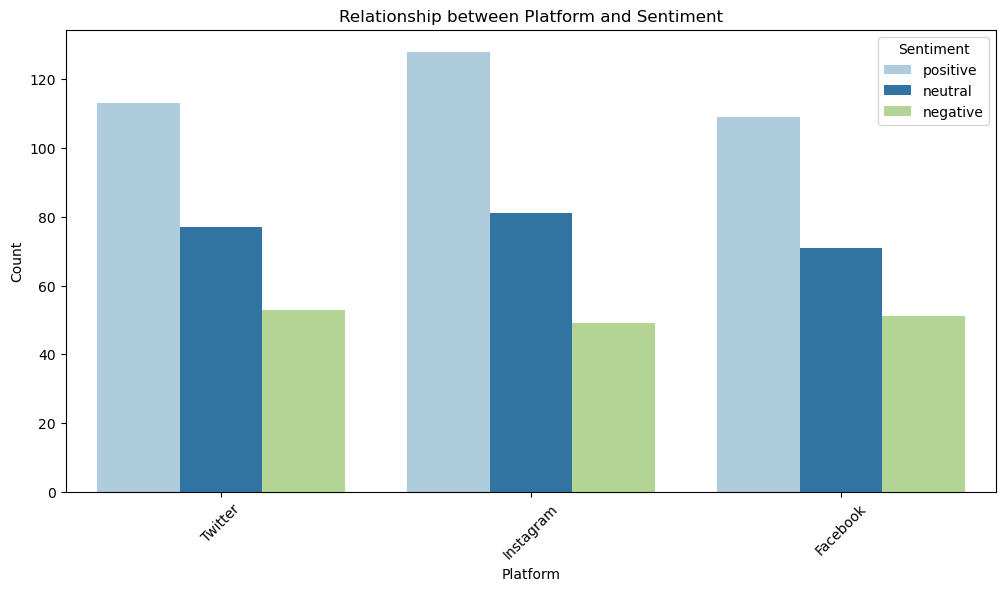

In [66]:

# paltform 

plt.figure(figsize=(12, 6))
sns.countplot(x='Platform', hue='Sentiment', data=df1, palette='Paired')
plt.title('Relationship between Platform and Sentiment')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### 2. common words 


In [72]:
df1['temp_list'] = df1['Clean_Text'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(10), columns=['Common_words', 'count']) # the 10 most common words 

top_words_df.style.background_gradient(cmap='Blues')


,Common_words,count
0,new,43
1,life,37
2,challeng,34
3,joy,31
4,danc,30
5,day,29
6,feel,29
7,like,28
8,dream,28
9,moment,27


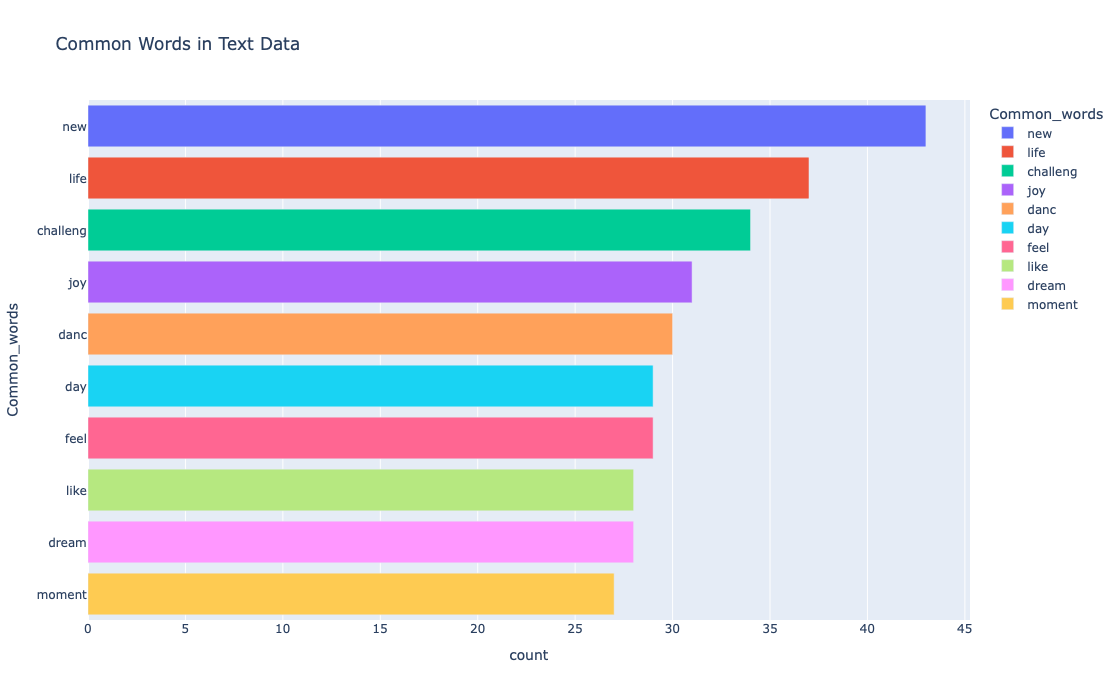

In [76]:
df1['temp_list'] = df1['Clean_Text'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df1['temp_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(10), columns=['Common_words', 'count'])

fig = px.bar(top_words_df,
            x="count",
            y="Common_words",
            title='Common Words in Text Data',
            orientation='h',
            width=700,
            height=700,
            color='Common_words')

fig.show()


### positive common words and visualization 

In [86]:


Positive_sent = df1[df1['Sentiment'] == 'positive']
Negative_sent = df1[df1['Sentiment'] == 'negative']
Neutral_sent = df1[df1['Sentiment'] == 'neutral']

top = Counter([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,joy,30
1,friend,24
2,laughter,24
3,new,21
4,challeng,20
5,life,20
6,hope,20
7,dream,20
8,embrac,19
9,like,19


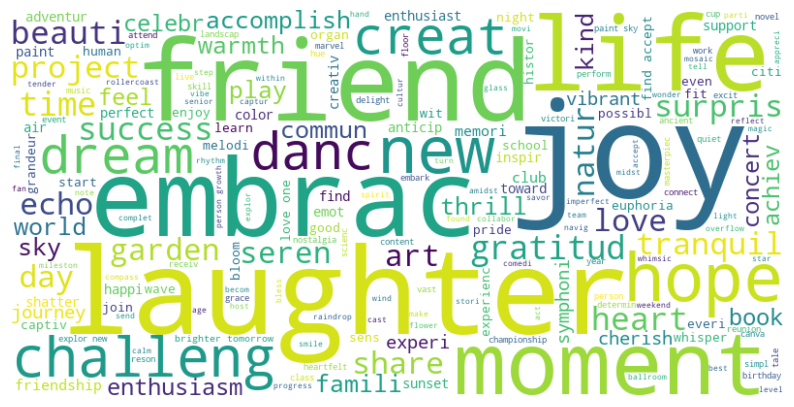

In [84]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'positive']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Negative Common Words for comparison 

In [90]:
top = Counter([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
temp_positive.style.background_gradient(cmap='Reds')


,Common_words,count
0,despair,14
1,lost,14
2,emot,13
3,feel,11
4,bitter,10
5,storm,10
6,day,9
7,like,9
8,grief,8
9,heart,8


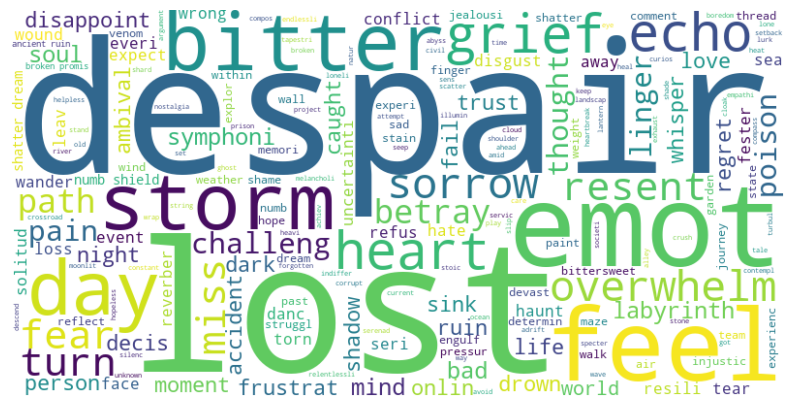

In [92]:
words = ' '.join([item for sublist in df1[df1['Sentiment'] == 'negative']['temp_list'] for item in sublist])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


# Machine Learning Model 

### Preprocessing data 

In [97]:
df2 = df1.copy()

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

In [101]:
# train and test split 

X = df2['Clean_Text'].values
y = df2['Sentiment'].values

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [109]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

'''
TF-IDF (Term Frequency-Inverse Document Frequency)
to convert text data into numerical features for machine learning models.'''


'\nTF-IDF (Term Frequency-Inverse Document Frequency)\nto convert text data into numerical features for machine learning models.'


### Passive Aggressive Classifier
 


In [111]:
pac_classifier = PassiveAggressiveClassifier(max_iter=50, random_state=42)
pac_classifier.fit(X_train_tfidf, y_train)

PassiveAggressiveClassifier(max_iter=50, random_state=42)

In [113]:
y_pred = pac_classifier.predict(X_test_tfidf)
accuracy_test = accuracy_score(y_test, y_pred)
classification_rep_test = classification_report(y_test, y_pred)

In [115]:
print("Test Set Results:")
print(f"Accuracy: {accuracy_test}")
print("Classification Report:\n", classification_rep_test)

Test Set Results:
Accuracy: 0.7142857142857143
Classification Report:
               precision    recall  f1-score   support

    negative       0.79      0.81      0.80        32
     neutral       0.73      0.55      0.62        55
    positive       0.67      0.82      0.74        60

    accuracy                           0.71       147
   macro avg       0.73      0.72      0.72       147
weighted avg       0.72      0.71      0.71       147




### Logistic Classifier



In [118]:
logistic_classifier = LogisticRegression(max_iter=50, random_state=42)
logistic_classifier.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=50, random_state=42)

In [122]:
y_pred_logistic = logistic_classifier.predict(X_test_tfidf)
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
classification_rep_logistic = classification_report(y_test, y_pred_logistic)

In [124]:
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_logistic}")
print("Classification Report:\n", classification_rep_logistic)


Logistic Regression Results:
Accuracy: 0.6326530612244898
Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.50      0.64        32
     neutral       0.80      0.36      0.50        55
    positive       0.55      0.95      0.70        60

    accuracy                           0.63       147
   macro avg       0.75      0.60      0.61       147
weighted avg       0.72      0.63      0.61       147



### Random Fores Classifier



In [127]:
random_forest_classifier = RandomForestClassifier(random_state=42)
random_forest_classifier.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [129]:
y_pred_rf = random_forest_classifier.predict(X_test_tfidf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)

In [131]:
print("\nRandom Forest Results:")
print(f"Accuracy: {accuracy_rf}")
print("Classification Report:\n", classification_rep_rf)


Random Forest Results:
Accuracy: 0.6530612244897959
Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.59      0.70        32
     neutral       0.77      0.44      0.56        55
    positive       0.56      0.88      0.69        60

    accuracy                           0.65       147
   macro avg       0.73      0.64      0.65       147
weighted avg       0.71      0.65      0.64       147



### SVM Classifier


In [133]:
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train_tfidf, y_train)

SVC(random_state=42)

In [136]:
y_pred_svm = svm_classifier.predict(X_test_tfidf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
classification_rep_svm = classification_report(y_test, y_pred_svm)

In [138]:
print("Support Vector Machine Results:")
print(f"Accuracy: {accuracy_svm}")
print("Classification Report:\n", classification_rep_svm)

Support Vector Machine Results:
Accuracy: 0.5986394557823129
Classification Report:
               precision    recall  f1-score   support

    negative       1.00      0.38      0.55        32
     neutral       0.94      0.31      0.47        55
    positive       0.50      0.98      0.67        60

    accuracy                           0.60       147
   macro avg       0.82      0.56      0.56       147
weighted avg       0.78      0.60      0.57       147



 ### Multinomial NB


In [141]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

MultinomialNB()

In [143]:
y_pred_nb = nb_classifier.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
classification_rep_nb = classification_report(y_test, y_pred_nb)

In [145]:
print("\nMultinomial Naive Bayes Results:")
print(f"Accuracy: {accuracy_nb}")
print("Classification Report:\n", classification_rep_nb)


Multinomial Naive Bayes Results:
Accuracy: 0.6190476190476191
Classification Report:
               precision    recall  f1-score   support

    negative       1.00      0.38      0.55        32
     neutral       0.90      0.35      0.50        55
    positive       0.53      1.00      0.69        60

    accuracy                           0.62       147
   macro avg       0.81      0.57      0.58       147
weighted avg       0.77      0.62      0.59       147



### Best Modeling : Passive Aggressive Classifier


Hyperparameters
        




In [149]:
param_dist = {
    'C': [0.1, 0.5, 1.0],
    'fit_intercept': [True, False],
    'shuffle': [True, False],
    'verbose': [0, 1],
}

In [151]:
pac_classifier = PassiveAggressiveClassifier(random_state=42)

randomized_search = RandomizedSearchCV(pac_classifier, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
randomized_search.fit(X_train_tfidf, y_train)

-- Epoch 1
Norm: 9.92, NNZs: 1467, Bias: -0.464986, T: 468, Avg. loss: 0.522383
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 13.91, NNZs: 1496, Bias: -0.370255, T: 936, Avg. loss: 0.189774
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 15.56, NNZs: 1505, Bias: -0.347198, T: 1404, Avg. loss: 0.071065
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 16.15, NNZs: 1505, Bias: -0.348670, T: 1872, Avg. loss: 0.023560
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 16.34, NNZs: 1505, Bias: -0.350289, T: 2340, Avg. loss: 0.006908
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 16.39, NNZs: 1505, Bias: -0.351797, T: 2808, Avg. loss: 0.001933
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 16.40, NNZs: 1505, Bias: -0.352221, T: 3276, Avg. loss: 0.000385
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 16.40, NNZs: 1505, Bias: -0.352292, T: 3744, Avg. loss: 0.000070
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 16.40, NNZs: 1505, Bias: -0.352296, T: 4212, Avg. 

RandomizedSearchCV(cv=5, estimator=PassiveAggressiveClassifier(random_state=42),
                   param_distributions={'C': [0.1, 0.5, 1.0],
                                        'fit_intercept': [True, False],
                                        'shuffle': [True, False],
                                        'verbose': [0, 1]},
                   random_state=42, scoring='accuracy')

In [153]:
best_params_randomized = randomized_search.best_params_
best_params_randomized

{'verbose': 0, 'shuffle': False, 'fit_intercept': True, 'C': 1.0}

In [155]:
best_pac_classifier_randomized = PassiveAggressiveClassifier(random_state=42, **best_params_randomized)
best_pac_classifier_randomized.fit(X_train_tfidf, y_train)

PassiveAggressiveClassifier(random_state=42, shuffle=False)

In [159]:
y_pred_best_pac_randomized = best_pac_classifier_randomized.predict(X_test_tfidf)

In [161]:
accuracy_best_pac_randomized = accuracy_score(y_test, y_pred_best_pac_randomized)
classification_rep_best_pac_randomized = classification_report(y_test, y_pred_best_pac_randomized)
conf_matrix_test = confusion_matrix(y_test, y_pred_best_pac_randomized)

In [163]:
print("Best PassiveAggressiveClassifier Model (RandomizedSearchCV):")
print(f"Best Hyperparameters: {best_params_randomized}")
print(f"Accuracy: {accuracy_best_pac_randomized}")
print("Classification Report:\n", classification_rep_best_pac_randomized)


Best PassiveAggressiveClassifier Model (RandomizedSearchCV):
Best Hyperparameters: {'verbose': 0, 'shuffle': False, 'fit_intercept': True, 'C': 1.0}
Accuracy: 0.7278911564625851
Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.81      0.83        32
     neutral       0.74      0.56      0.64        55
    positive       0.68      0.83      0.75        60

    accuracy                           0.73       147
   macro avg       0.75      0.74      0.74       147
weighted avg       0.73      0.73      0.72       147



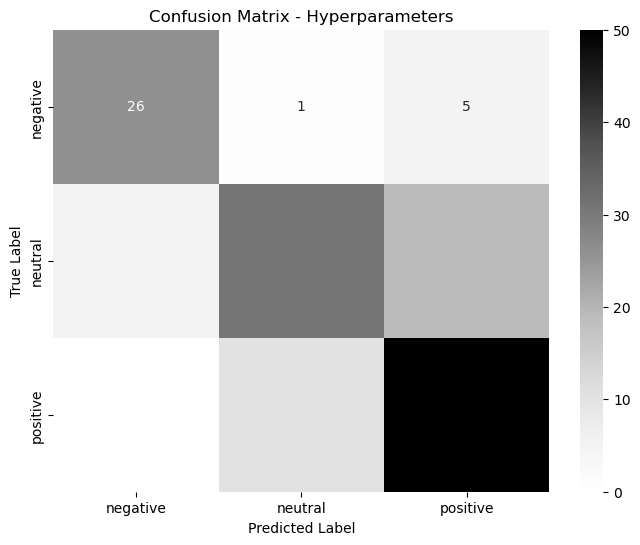

In [165]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Greys', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix - Hyperparameters')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
